In [1]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop, Adam
import os

Using TensorFlow backend.


In [2]:
batch_size = 128 # batch 的大小，如果出現 OOM error，請降低這個值
num_classes = 10 # 類別的數量，Cifar 10 共有 10 個類別
epochs = 10 # 訓練的 epochs 數量

# 讀取資料並檢視
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# 對 label 進行 one-hot encoding (y_trian 原本是純數字)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


## 首先我們使用一般的 DNN (MLP) 來訓練
由於 DNN 只能輸入一維的資料，我們要先將影像進行攤平，若 (50000, 32, 32, 3) 的影像，攤平後會變成 (50000, 32\*32\*3) = (50000, 3072)

In [3]:
# 將資料攤平成一維資料
x_train = x_train.reshape(50000, 3072) 
x_test = x_test.reshape(10000, 3072)

# 將資料變為 float32 並標準化
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

50000 train samples
10000 test samples


In [4]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(3072,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 1,841,162
Trainable params: 1,841,162
Non-trainable params: 0
___________

## 接下來我們使用 CNN 來訓練神經網路
CNN 的原理非常適合處理影像類的資料，就讓我們來看看，同樣的訓練條件，CNN 是否顯著優於 DNN 呢?

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [4]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)  

## 同樣運算 10 個 epochs，但 CNN 在 test data 的準確率顯著優於 DNN!

## 作業
1. 請試著調整各個超參數，並說明那些超參數對於結果有明顯的影響?
2. CNN 與 DNN 哪個模型的參數數量比較多? 造成參數的數量不同的原因在哪?

#### 1. 請試著調整各個超參數，並說明那些超參數對於結果有明顯的影響? filter size, number of filters, pooling size...

In [5]:
FILTER_SIZE = [3, 5]
NUM_FILTERS = [[32, 32, 64, 64],
               [16, 16, 32, 32],
               [16, 32, 64, 128]]
POOLING_SIZE = [2, 3]

In [7]:
import itertools
results = {}

for filter_size, num_filters, pooling in itertools.product(FILTER_SIZE, NUM_FILTERS, POOLING_SIZE):
    print("Filter_size=%s; num_filters=%s; pooling_size=%s" % (str(filter_size), str(num_filters), str(pooling)))
    model = Sequential()
    model.add(Conv2D(num_filters[0], (filter_size, filter_size), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(num_filters[1], (filter_size, filter_size)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(pooling, pooling)))
    model.add(Dropout(0.25))

    model.add(Conv2D(num_filters[2], (filter_size, filter_size), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(num_filters[3], (filter_size, filter_size)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(pooling, pooling)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(),
                  metrics=['accuracy'])

    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test))    
    # Collect results
    exp_name_tag = ("F%s-N%s-P%s" % (str(filter_size), str(num_filters), str(pooling)))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Filter_size=3; num_filters=[32, 32, 64, 64]; pooling_size=2
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 157s 3ms/step - loss: 1.7651 - acc: 0.3644 - val_loss: 1.7690 - val_acc: 0.4294
Epoch 2/10
50000/50000 [==============================] - 153s 3ms/step - loss: 1.3013 - acc: 0.5379 - val_loss: 1.1966 - val_acc: 0.5799
Epoch 3/10
50000/50000 [==============================] - 154s 3ms/step - loss: 1.0904 - acc: 0.6184 - val_loss: 1.0496 - val_acc: 0.6341
Epoch 4/10
50000/50000 [==============================] - 145s 3ms/step - loss: 0.9648 - acc: 0.6634 - val_loss: 0.8264 - val_acc: 0.7117
Epoch 5/10
50000/50000 [==============================] - 146s 3ms/step - loss: 0.8747 - acc: 0.6976 - val_loss: 0.8877 - val_acc: 0.7012
Epoch 6/10
50000/50000 [==============================] - 144s 3ms/step - loss: 0.8081 - acc: 0.7201 - val_loss: 0.7821 - val_acc: 0.7319
Epoch 7/10
50000/50000 [==============================] - 143s

Epoch 6/10
50000/50000 [==============================] - 100s 2ms/step - loss: 0.9672 - acc: 0.6630 - val_loss: 0.9078 - val_acc: 0.6851
Epoch 7/10
50000/50000 [==============================] - 101s 2ms/step - loss: 0.9130 - acc: 0.6848 - val_loss: 0.8770 - val_acc: 0.6919
Epoch 8/10
50000/50000 [==============================] - 103s 2ms/step - loss: 0.8747 - acc: 0.6978 - val_loss: 0.8224 - val_acc: 0.7119
Epoch 9/10
50000/50000 [==============================] - 91s 2ms/step - loss: 0.8371 - acc: 0.7087 - val_loss: 0.7659 - val_acc: 0.7374
Epoch 10/10
50000/50000 [==============================] - 86s 2ms/step - loss: 0.8055 - acc: 0.7200 - val_loss: 0.7967 - val_acc: 0.7251
Filter_size=5; num_filters=[32, 32, 64, 64]; pooling_size=2
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 266s 5ms/step - loss: 2.0834 - acc: 0.2569 - val_loss: 1.7957 - val_acc: 0.3513
Epoch 2/10
50000/50000 [==============================] - 262s 

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 134s 3ms/step - loss: 1.9388 - acc: 0.2876 - val_loss: 1.5474 - val_acc: 0.4408
Epoch 2/10
50000/50000 [==============================] - 133s 3ms/step - loss: 1.4842 - acc: 0.4674 - val_loss: 1.2999 - val_acc: 0.5392
Epoch 3/10
50000/50000 [==============================] - 132s 3ms/step - loss: 1.2789 - acc: 0.5493 - val_loss: 1.2488 - val_acc: 0.5528
Epoch 4/10
50000/50000 [==============================] - 132s 3ms/step - loss: 1.1341 - acc: 0.6053 - val_loss: 1.0406 - val_acc: 0.6336
Epoch 5/10
50000/50000 [==============================] - 132s 3ms/step - loss: 1.0265 - acc: 0.6434 - val_loss: 0.9255 - val_acc: 0.6793
Epoch 6/10
50000/50000 [==============================] - 132s 3ms/step - loss: 0.9435 - acc: 0.6738 - val_loss: 0.9754 - val_acc: 0.6666
Epoch 7/10
50000/50000 [==============================] - 133s 3ms/step - loss: 0.8881 - acc: 0.6954 - val_loss: 0.8825 - 

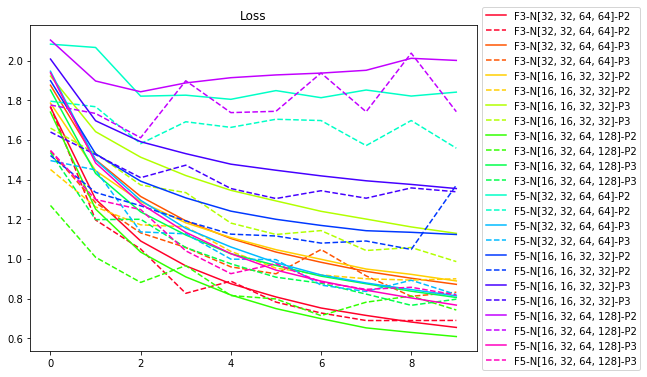

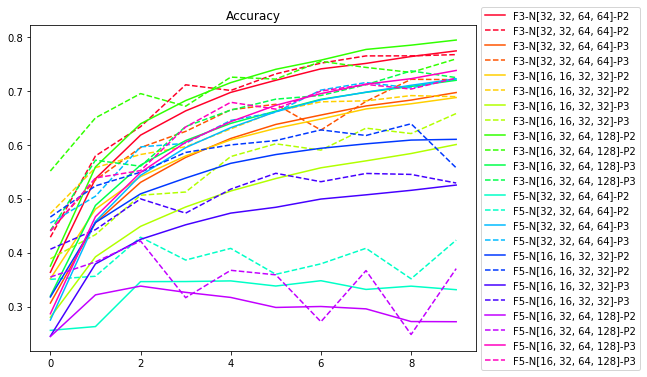

In [8]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#### 2. CNN 與 DNN 哪個模型的參數數量比較多? 造成參數的數量不同的原因在哪?
### DNN 參數數量較多，因為 CNN 中 filter 和 pooling 的使用可以有效降低參數數量